In [1]:
cd /home/dongdong/SCR/chi1.run02/iter50

/scratch/gpfs/dongdong/chi1.run02/iter50


In [3]:
import re
import os
import sys
import json
import argparse
import pylab
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

kbT = (8.617343E-5) * 300 
beta = 1.0 / kbT
f_cvt = 96.485

EPSILON = 1e-8

def load_graph(frozen_graph_filename, 
               prefix = 'load'):
    # We load the protobuf file from the disk and parse it to retrieve the 
    # unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    # Then, we can use again a convenient built-in function to import a graph_def into the 
    # current default Graph
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(
            graph_def, 
            input_map=None, 
            return_elements=None, 
            name=prefix, 
            op_dict=None, 
            producer_op_list=None
        )
    return graph

class Walker(object):
    def __init__(self, fd, nw, sess):
        self._full_dim = fd
        self._num_walker = nw
        self._move_scale = 0.5
        self._sess = sess
        self._shape = (self._num_walker, self._full_dim)
        # absolute coordinate
        self._position = np.random.uniform(size=self._shape) * np.pi * 2
        self._energy = np.zeros([self._num_walker])
        self._force = np.zeros([self._num_walker, self._full_dim])
        self._sample_step = 20
        self._acp_ratio_lb = 0.15
        self._acp_ratio_ub = 0.75
        self.max_scale = np.pi
        self.min_scale = 0.01
        self.inc_scale_fac = 1.25

    def sample(self, compute_ef, inter_step=1):
        acp_ratio = []
        self._energy, self._force = compute_ef(self._sess, self._position)
        for _ in range(inter_step):
            position_new = np.mod(self._position + np.random.normal(scale=self._move_scale,
                                                             size=self._shape), 2*np.pi)
            energy_new, force_new = compute_ef(self._sess, position_new)
            # in case of overflow
            prob_ratio = np.exp(np.minimum(- beta * (energy_new - self._energy), 0))
            idx = np.random.uniform(size=self._num_walker) < np.reshape(prob_ratio, [-1])
            self._position[idx, :] = position_new[idx, :]
            self._energy[idx] = energy_new[idx]
            self._force[idx] = force_new[idx]
            acp_ratio.append(np.mean(idx))
        acp_ratio = np.mean(acp_ratio)
        if acp_ratio > self._acp_ratio_ub:
            # move_scale is too small
            self._move_scale = min(
                self._move_scale*self.inc_scale_fac,
                self.max_scale)
            print(
                "Increase move_scale to %f due to high acceptance ratio: %f" % (
                    self._move_scale, acp_ratio))
            # print(self._position[:5, :, :])
        elif acp_ratio < self._acp_ratio_lb:
            # move_scale is too large
            self._move_scale = max(
                self._move_scale/self.inc_scale_fac,
                self.min_scale)
            print(
                "Decrease move_scale to %f due to low acceptance ratio: %f" % (
                    self._move_scale, acp_ratio))
        return self._position, self._energy, self._force


def compute_ef (sess, position) :
    graph = sess.graph

    inputs  = graph.get_tensor_by_name ('load/inputs:0')
    o_energy= graph.get_tensor_by_name ('load/o_energy:0')
    o_forces= graph.get_tensor_by_name ('load/o_forces:0')

    zeros = 0.0 * position
    data_inputs = np.concatenate ((position, zeros), axis = 1)
    feed_dict_test = {inputs: data_inputs}

    data_ret = sess.run ([o_energy, o_forces], feed_dict = feed_dict_test)
    return data_ret[0], data_ret[1]


In [4]:
def _main () :
    parser = argparse.ArgumentParser()
    parser.add_argument("-m", "--model", default=[], nargs = '*', type=str, 
                        help="Frozen model file to test")
    parser.add_argument("-fd", "--full_dimension", default = 4, type=int, 
                        help="The dimensionality of FES")
    parser.add_argument("-ns", "--num_step", default = 1000000, type=int,
                        help="number of mc step")
    parser.add_argument("-nw", "--num_walker", default=2000, type=int, 
                        help="number of walker")
    args = parser.parse_args()

    model = args.model 
    fd = args.full_dimension
    ns = args.num_step
    nw = args.num_walker
    positons = []
    energies = []
    forces = []
    graph = load_graph (model[0])

    with tf.Session(graph = graph) as sess:        
        walker = Walker(fd, nw, sess)
        for ii in range(ns):
            pp, ee, ff = walker.sample(compute_ef)
            print(pp)
            for dd in range(fd):
                fp = open("angle%d.dat" %dd, "a")
                np.savetxt(fp,np.array(pp[:,dd]))

In [5]:
graph = load_graph ('graph.000.pb')

In [54]:
pwd

'/scratch/gpfs/dongdong/pdz.run02'

In [59]:
aa=np.random.uniform(low=-550.0, high=-500.0,size=1000)
bb=np.random.uniform(low=0, high=20,size=1000)

In [60]:
wf=open('test','w')
for i in range(500):
    wf.write(str(bb[i])+'    '+str(aa[i])+'\n')
wf.close()

In [12]:
shape=(1000,3)

In [13]:
pp=np.random.uniform(size=shape) * np.pi * 2

In [31]:
3//2

1

In [43]:
xx = pylab.linspace(0,2* np.pi, 25)

In [18]:
yy = pylab.linspace(0,2* np.pi, 100)

In [51]:
delta = 2.0 * np.pi / 25

In [21]:
def my_hist(pp, xx, yy, delta, fd):
    my_hist = np.zeros((fd, len(xx), len(yy)))
    for ii in range(pp.shape[0]):
        for jj in range(fd):
            my_hist[jj, np.int(pp[ii,jj*2+0]//delta)-50, np.int(pp[ii,jj*2+1]//delta)-50] += 1
    my_hist /= (pp.shape[0] * delta * delta)
    return my_hist

In [30]:
my_hist(pp,xx,yy,delta,3//2).shape

(1, 100, 100)

In [32]:
my_hist = np.zeros((1, len(xx), len(yy)))

In [35]:
pp

array([[ 2.23823806,  2.72752975,  0.27490474],
       [ 2.94836915,  1.65758656,  5.05060946],
       [ 5.46675082,  2.1744026 ,  5.39380325],
       ..., 
       [ 3.14662569,  1.09107176,  4.11636786],
       [ 5.30275199,  4.88408651,  3.37828574],
       [ 5.40357811,  1.9530321 ,  3.24997643]])

In [44]:
xx

array([ 0.        ,  0.26179939,  0.52359878,  0.78539816,  1.04719755,
        1.30899694,  1.57079633,  1.83259571,  2.0943951 ,  2.35619449,
        2.61799388,  2.87979327,  3.14159265,  3.40339204,  3.66519143,
        3.92699082,  4.1887902 ,  4.45058959,  4.71238898,  4.97418837,
        5.23598776,  5.49778714,  5.75958653,  6.02138592,  6.28318531])

In [55]:
len(pp[:,0])

1000

In [45]:
my_hist = np.zeros((1, len(xx)))


In [62]:
for ii in range(pp.shape[0]):   ###trj_num
           ###cv_num
    my_hist[0, np.int(pp[ii,0]//delta)] += 1

In [65]:
my_hist

array([[ 46.18302818,  35.13926058,  31.12334508,  33.13130283,
         41.16313382,  44.17507044,  39.15517607,  36.14323945,
         48.19098593,  37.14721832,  47.18700706,  44.17507044,
         37.14721832,  39.15517607,  46.18302818,  41.16313382,
         42.16711269,  31.12334508,  40.15915494,  38.1511972 ,
         35.13926058,  50.19894368,  43.17109156,  34.1352817 ,
         43.17109156]])

In [75]:
aa=my_hist/1000.0

In [77]:
pp_hist = np.zeros((3, len(xx)))

In [68]:
pp_hist=(my_hist/1000.0+my_hist/1000.0)/2

In [79]:
pp_hist[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [70]:
-np.log(pp_hist+1e-6)

array([[ 3.07512125,  3.34840778,  3.46976497,  3.40724656,  3.19018794,
         3.11957203,  3.24019711,  3.32023769,  3.03256254,  3.29283947,
         3.05361551,  3.11957203,  3.29283947,  3.24019711,  3.07512125,
         3.19018794,  3.16609097,  3.46976497,  3.21487995,  3.26617193,
         3.34840778,  2.99174137,  3.14256102,  3.37739448,  3.14256102]])

In [82]:
aa=np.random.uniform(size=2) * np.pi * 2

In [85]:
np.append(aa,aa)

array([ 2.46033012,  1.71172765,  2.46033012,  1.71172765])

In [89]:
def singleSD(nList,refList):
    length=len(nList)
    sumVar=0.0
    for i in range(length):
        sub=nList[i]-refList[i]
        sumVar+=np.cos(sub)+1
    return sumVar/2


In [97]:
singleSD([np.pi,0],[1/2*np.pi,1/2*np.pi])

1.0

In [109]:
aa=np.append(np.random.uniform(size=(20,9)) * np.pi * 2 , np.random.uniform(size=(20,3)) * 3.6, axis=1)

In [111]:
len(aa)

20

In [123]:
aa[9:12]/2

array([[ 1.80582477,  1.50184073,  2.29182126,  1.00867871,  2.49437565,
         2.48573934,  0.78676972,  1.74008314,  0.10518247,  1.57235283,
         0.4711027 ,  1.6977261 ],
       [ 1.84731528,  2.46380661,  0.97026328,  2.55042023,  0.96937042,
         0.19789753,  0.63363915,  2.20529549,  2.84412043,  0.79912297,
         0.56602021,  0.3695279 ],
       [ 2.22321974,  0.1476044 ,  2.65514885,  0.44162033,  1.07929454,
         0.55799503,  1.07478204,  2.04457673,  3.02206653,  0.18704271,
         1.23019675,  0.20924   ]])

In [61]:
cd /home/dongdong/SCR/pdz.run02/mc3/iter70/000_t

/scratch/gpfs/dongdong/pdz.run02/mc3/iter70/000_t


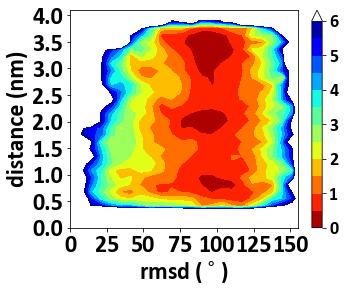

In [9]:
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib
import pylab
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
font_path = '/home/dongdong/tigress/calibribold.ttf'
font_prop = font_manager.FontProperties(fname=font_path, size=24)
leg_prop = font_manager.FontProperties(fname=font_path, size=18)
data=np.loadtxt('/home/dongdong/SCR/pdz.run02/mc4/iter75_1/2d_step100000.dat')
fig = plt.figure(figsize=(5.1, 4))
ax = fig.add_subplot(111)
cmap = plt.cm.get_cmap("jet_r")
#CS = plt.contourf(xedges[1:],yedges[1:],H,levels = np.linspace(0,1000000,11),cmap=cmap,extend="max")
#lvls = np.logspace(0,3,15)
cmap.set_over("white")
bins=30
xx = pylab.linspace(0,200, bins)
yy = pylab.linspace(0,4.1-0.2, bins)

CS = plt.contourf(xx,yy,data,levels = np.linspace(0,6,13),cmap=cmap,extend="max")
#CS = plt.contourf(xi,xi,np.reshape(data[:,2]/4.18,(-1,61)),cmap=cmap,extend="max")
cbar = plt.colorbar(CS)
#plt.scatter(data_ave[:,0],data_ave[:,1],s=18)
#plt.scatter(data_ave[:,0],data_ave[:,1],c=pcca,cmap='tab20c',s=14)
#plt.errorbar(data_ave[:,2],data_ave[:,0],xerr=data_ave[:,3],yerr=data_ave[:,1],fmt=None)
plt.xlabel(r'rmsd ($^\circ$)',fontproperties=font_prop)
plt.ylabel(r'distance (nm)',fontproperties=font_prop)
#plt.xlabel(r'$\phi$ (rad)')
plt.ylim(0,4.1)
plt.xlim(0,155)
#leg=plt.legend(loc=1, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1.5)
#leg.get_frame().set_linewidth(0.0)
#leg.get_frame().set_alpha(0.1)
for label in (ax.get_xticklabels() + ax.get_yticklabels()+cbar.ax.get_yticklabels()):
    label.set_fontproperties(font_prop)
for label in cbar.ax.get_yticklabels():
    label.set_fontproperties(leg_prop)
#plt.savefig('/home/dongdong/SCR/pdz.run02/mc3/2CV.png',dpi=600,bbox_inches='tight')
    #label.set_fontsize(16)
#plt.imshow(HH, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],levels = np.linspace(1,6,20))
plt.show()

In [92]:
shape1 = (3, 5)
dist1=np.random.uniform(0.3,3.8,size=shape1)

In [93]:
alldist=[]
dist2=np.zeros([3,5])

In [94]:
alldist.append(dist1)
alldist.append(dist2)

In [100]:
bb=np.reshape(alldist,[2,3,5])
bb

array([[[ 1.69725968,  1.13562155,  2.56517651,  2.35848759,  1.52947145],
        [ 2.75598922,  1.92823249,  1.90652377,  3.5104485 ,  1.24748597],
        [ 1.53121699,  2.47990592,  0.54854575,  3.15082416,  1.51271328]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]])

In [101]:
a_std=np.std(bb,axis=0)
a_std

array([[ 0.84862984,  0.56781078,  1.28258826,  1.1792438 ,  0.76473573],
       [ 1.37799461,  0.96411625,  0.95326188,  1.75522425,  0.62374299],
       [ 0.7656085 ,  1.23995296,  0.27427288,  1.57541208,  0.75635664]])

In [104]:
np.std(a_std,axis=1)

array([ 0.26515867,  0.39174945,  0.44709895])

In [122]:
kbT = (8.617343E-5) * 300
beta = 1.0 / kbT
beta

38.68168336032734

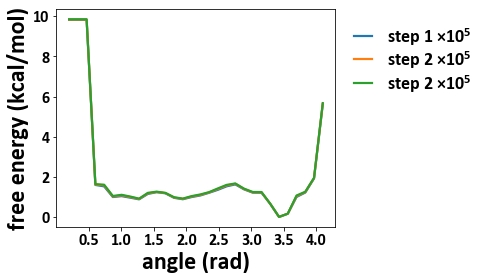

In [25]:
xx = np.linspace(-np.pi, np.pi, 25)
for iii in range(1,2):
    fig = plt.figure(figsize=(5,4))
    sub = fig.add_subplot(1,1,1)
    data=np.loadtxt('/home/dongdong/SCR/pdz.run02/mc3/iter65/000/1CV2_index%d.dat' %iii)
    i=1
    for i in [3,4,5]:
        lab=i*5/10
        plt.plot(yy,data[i],lw=2.2,label=r'step %d $\mathregular{\times 10^5}$' %lab)
    
        
    for label in (sub.get_xticklabels() + sub.get_yticklabels()):
        label.set_fontproperties(font_prop)
        label.set_fontsize(16)
    leg=plt.legend(loc=2, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1,bbox_to_anchor=(1.01,1.0))
    leg.get_frame().set_linewidth(0.0)
    leg.get_frame().set_alpha(0.1)
    plt.ylabel(r'free energy (kcal/mol)',fontproperties=font_prop)
    plt.xlabel(r'angle (rad)',fontproperties=font_prop)
    #plt.ylim(1,10000)
    #plt.savefig('/home/dongdong/SCR/chi3.run01/mc/iter140_0/Energy_CV%d.png' %iii,dpi=600,bbox_inches='tight')
    plt.show()

In [119]:
alldata=np.zeros((25,25))

In [120]:
fig = plt.figure(figsize=(5,4))
sub = fig.add_subplot(1,1,1)
for jj in [6,10,14]:
    alldata=[]
    for kk in range(1,2):
        data=np.loadtxt('/home/dongdong/SCR/chi3.run01/mc/iter%d0_%d/1CV_index%d.dat' %(jj,kk,cv))
        alldata.append(data[-1]-np.min(data[-1]))
    ave=np.mean(alldata,axis=0)
    sd=np.std(alldata,axis=0)
    plt.plot(xx,ave,lw=2.2,label=r'iter%d0' %jj)
    plt.fill_between(xx, ave - sd,ave + sd, alpha=0.4 )
    
for label in (sub.get_xticklabels() + sub.get_yticklabels()):
    label.set_fontproperties(font_prop)
    label.set_fontsize(16)
leg=plt.legend(loc=2, labelspacing=0.1, prop=leg_prop, scatterpoints=1, markerscale=1, numpoints=1,handlelength=1,bbox_to_anchor=(1.01,1.0))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_alpha(0.1)
plt.ylabel(r'free energy (kcal/mol)',fontproperties=font_prop)
plt.xlabel(r'angle (rad)',fontproperties=font_prop)
#plt.ylim(1,10000)
plt.savefig('/home/dongdong/SCR/chi3.run01/mc/Energy_CV%d_all.png' %cv,dpi=600,bbox_inches='tight')
plt.show()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
      

In [124]:
def singleSD(nList,refList):
    length=len(nList)
    sumVar=0.0
    for i in range(length):
        sub=nList[i]-refList[i]
        if np.abs(sub)>180:
            sub=360-np.abs(sub)
        sumVar+=sub**2
    return ((float(sumVar)/float((length)))**0.5)


In [129]:
singleSD(aa[1,0:9]/3.14*180,aa[1,0:9]/3.14*180)

0.0

In [134]:
from multiprocessing.dummy import Pool as ThreadPool

In [165]:
nList=np.array([180,0,-90,-190])
refList=np.array([180,0,100,10])
singleSD(nList,refList)

116.72617529928752

In [158]:
aa=nList-refList

In [159]:
bb=np.abs(aa)

In [160]:
bb[bb>180]=360-bb[bb>180]

In [168]:
np.sqrt(np.mean(bb**2))

116.72617529928752

array([    0,     0, 28900, 25600])

In [169]:
def singleSD2(nList,refList):
    aa=nList-refList
    bb=np.abs(aa)
    bb[bb>180]=360-bb[bb>180]
    return np.sqrt(np.mean(bb**2))

In [170]:
singleSD2(nList,refList)

116.72617529928752

In [203]:
aa=np.random.normal(loc=[-1,2,0.7],scale=0.1,size=(5,3))
bb=np.random.normal(loc=[1,1,2],scale=0.2,size=(5,3))

In [204]:
aa

array([[-0.86803731,  2.04180099,  0.765089  ],
       [-1.10777261,  1.85161532,  0.65086491],
       [-0.82928559,  1.91503844,  0.7016117 ],
       [-1.12799231,  2.0322661 ,  0.66291242],
       [-1.00225842,  2.1558654 ,  0.57236127]])

In [200]:
bb

array([[ 1.09718788,  1.23741722,  2.04502989],
       [ 1.17017698,  0.81833002,  2.02288416],
       [ 1.05594815,  1.09986681,  1.72349335],
       [ 1.19548134,  1.16307183,  2.24286845],
       [ 1.25988222,  1.10338197,  2.07098531]])

In [205]:
np.append(aa,bb,axis=0)

array([[-0.86803731,  2.04180099,  0.765089  ],
       [-1.10777261,  1.85161532,  0.65086491],
       [-0.82928559,  1.91503844,  0.7016117 ],
       [-1.12799231,  2.0322661 ,  0.66291242],
       [-1.00225842,  2.1558654 ,  0.57236127],
       [ 1.02540387,  1.40155772,  2.0700586 ],
       [ 1.03238615,  1.04794426,  1.86039324],
       [ 1.08837928,  0.83780326,  1.69511056],
       [ 1.08283775,  0.78946355,  1.88409363],
       [ 1.38928825,  0.78639642,  2.05139317]])

In [33]:
cd /home/dongdong/SCR/pdz.run02

/scratch/gpfs/dongdong/pdz.run02


/home/dongdong/software/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


0.0273706099213
0.452728762594


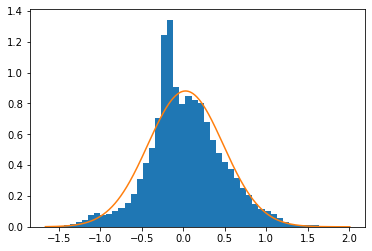

In [45]:
from scipy import stats
data=np.loadtxt('cha01_.dat')
plt.hist(data,bins=50,normed=True)
xmin, xmax = np.min(data), np.max(data)
lnspc = np.linspace(xmin, xmax, len(data))
m, s = stats.norm.fit(data) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
print(m)
print(s)

0.0273706099213
0.452728762594


/home/dongdong/software/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


-0.102028664359
0.593501792854


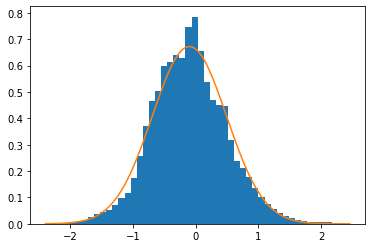

In [44]:
from scipy import stats
data=np.loadtxt('cha02_.dat')
plt.hist(data,bins=50,normed=True)
xmin, xmax = np.min(data), np.max(data)
lnspc = np.linspace(xmin, xmax, len(data))
m, s = stats.norm.fit(data) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
print(m)
print(s) 

/home/dongdong/software/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


-0.12939927428
0.436366365106


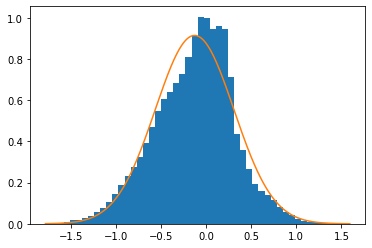

In [43]:
from scipy import stats
data=np.loadtxt('cha12_.dat')
plt.hist(data,bins=50,normed=True)
xmin, xmax = np.min(data), np.max(data)
lnspc = np.linspace(xmin, xmax, len(data))
m, s = stats.norm.fit(data) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
print(m)
print(s)

In [129]:
data=np.loadtxt('/home/dongdong/SCR/pdz.run02/iter.000083/02.train/data/data.raw')

/home/dongdong/software/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


(array([  1.63313500e-05,   0.00000000e+00,   6.53254001e-05,
          1.63313500e-05,   6.53254001e-05,   8.16567501e-05,
          1.30650800e-04,   1.30650800e-04,   2.44970250e-04,
          3.42958351e-04,   5.38934551e-04,   1.02887505e-03,
          1.24118260e-03,   2.09041280e-03,   3.05396245e-03,
          4.37680181e-03,   6.20591301e-03,   8.13301231e-03,
          1.05663835e-02,   1.33427130e-02,   1.77031834e-02,
          2.04958443e-02,   2.23902809e-02,   2.51829417e-02,
          2.66037692e-02,   2.77959577e-02,   2.75999815e-02,
          2.65874378e-02,   2.42520548e-02,   2.02835367e-02,
          1.74092191e-02,   1.40286297e-02,   1.06480402e-02,
          7.56141506e-03,   5.69964116e-03,   4.26248236e-03,
          2.66201005e-03,   1.69846040e-03,   1.22485125e-03,
          7.51242101e-04,   4.89940501e-04,   3.75621051e-04,
          2.28638900e-04,   1.63313500e-04,   4.89940501e-05,
          3.26627001e-05,   4.89940501e-05,   1.63313500e-05,
        

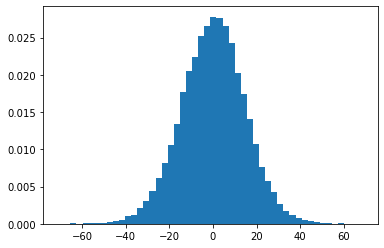

In [140]:
plt.hist(data[:,-7],bins=50,normed=True)

In [ ]:
data=np.loadtxt()

In [29]:
hh=np.random.uniform(size=(20,1)) * 3.1+0.5

In [32]:
hh+np.random.normal(scale=0.2,size=(20,1),loc=0.5)

array([[ 2.40944656],
       [ 1.58472011],
       [ 2.82605024],
       [ 1.91031948],
       [ 2.26901069],
       [ 2.83567756],
       [ 1.59880043],
       [ 3.09054631],
       [ 3.27628541],
       [ 1.28114022],
       [ 1.38329401],
       [ 3.75045982],
       [ 3.19045484],
       [ 2.2048975 ],
       [ 3.10508136],
       [ 1.39528814],
       [ 2.82022333],
       [ 2.96564012],
       [ 1.41935231],
       [ 3.81624166]])

In [259]:
aa=np.concatenate((hh,hh,hh),axis=1)

In [264]:
aa[:,1].reshape(-1,1)

array([[ 3.21780359],
       [ 1.7123689 ],
       [ 2.16147353],
       [ 2.78336937],
       [ 0.59953027],
       [ 2.7636375 ],
       [ 3.26881336],
       [ 1.37609316],
       [ 2.75830971],
       [ 3.06328804],
       [ 1.65595548],
       [ 0.53052593],
       [ 1.26673966],
       [ 1.17212748],
       [ 3.34526895],
       [ 0.84843914],
       [ 0.5523349 ],
       [ 1.93980528],
       [ 2.02821444],
       [ 1.69846846]])

In [280]:
shape11=(5,1)

In [278]:
position_dist1=np.random.uniform(0.3,3.8,size=(5,1))
position_dist1

array([[ 1.89909318],
       [ 2.25328859],
       [ 1.13899786],
       [ 0.47169991],
       [ 1.63672447]])

In [295]:
position_dist0=position_dist1+np.random.normal(scale=0.5,size=shape11)

In [296]:
position_dist0

array([[ 3.15546444],
       [ 2.69088633],
       [ 1.04479655],
       [-0.11315357],
       [ 2.04670814]])

In [283]:
position_dist0[position_dist0<0.3]=0.3

In [2]:
import numpy as np
shape1 = (2, 1)
position0=np.random.uniform(0.35,1,size=shape1)
position1=np.random.uniform(5,19,size=shape1)
position2=np.random.uniform(0,5.5,size=shape1)
position3=np.random.uniform(2,14.5,size=shape1)
position4=np.random.uniform(4,16,size=shape1)
position5=np.random.uniform(0,14,size=shape1)
position = np.concatenate((position0,position1,position2,position3,position4,position5), axis=1)


In [22]:
position

array([[  0.48732651,  15.69586253,   3.25887858,   3.37118003,
          4.97283863,   7.99624378],
       [  0.57335765,   7.4293407 ,   0.0281108 ,  12.04084679,
          4.68802716,   7.80631227]])

In [23]:
position.shape[0]

2

In [10]:
move_scale=np.array([0.1,1,2,3,4,5])

In [11]:
move_scale

array([ 0.1,  1. ,  2. ,  3. ,  4. ,  5. ])

In [12]:
np.random.normal(scale=move_scale,size=(2,6))

array([[  0.20345197,   1.81007743,   1.24618104,  -4.40592085,
         -7.57537882,  13.65109696],
       [  0.11566184,   0.05905778,  -2.55594419,   4.91872312,
         -0.46217503,  -5.73512901]])

In [17]:
np.mod(0.1,1)


0.10000000000000001

In [25]:
my_hist = np.random.normal(scale=2,size=(6,20))

In [26]:
my_hist

array([[ 1.09478461,  1.47064141, -0.56420133, -0.71603566, -1.7345364 ,
         2.63613232,  0.39930858, -0.33728606, -0.14709241, -0.88913445,
         1.74237553, -2.1710165 ,  1.36903436,  1.39061535,  2.42498032,
         0.72680228,  0.20631925, -0.48048933, -4.70417634,  1.58707192],
       [-1.35542755,  2.35668662, -3.36147566,  1.1810772 ,  0.85331876,
        -1.12251284,  0.68815626,  0.88186368, -0.29410267, -1.15221574,
         1.46458825,  1.15509661,  0.47604526, -1.34742602, -0.87149586,
        -1.39458459,  2.64375006, -1.11703957, -2.16811742, -0.90087624],
       [ 1.22638762, -2.26570433,  1.0715839 , -0.39776134,  1.11190391,
        -2.53108307, -0.71448139, -0.91156748,  1.3690436 ,  3.2519139 ,
        -2.80357123,  5.35429224,  1.23966806,  0.65369691, -2.31520865,
         2.96735149,  4.66434394,  0.6196747 ,  3.27009952,  1.47546229],
       [-0.81436034,  0.33052194, -0.63337049,  1.62570187,  0.53070958,
         1.67960269,  1.82500779, -3.70144014,  

In [20]:
allrange=np.array([1,19,5.5,14.5,16,14])
delta=allrange/(20)

In [28]:
delta.reshape(-1,1)*position.shape[0]

array([[ 0.1 ],
       [ 1.9 ],
       [ 0.55],
       [ 1.45],
       [ 1.6 ],
       [ 1.4 ]])

In [29]:
my_hist/=delta.reshape(-1,1)*position.shape[0]
my_hist

array([[  1.09478461e+01,   1.47064141e+01,  -5.64201333e+00,
         -7.16035663e+00,  -1.73453640e+01,   2.63613232e+01,
          3.99308576e+00,  -3.37286064e+00,  -1.47092414e+00,
         -8.89134455e+00,   1.74237553e+01,  -2.17101650e+01,
          1.36903436e+01,   1.39061535e+01,   2.42498032e+01,
          7.26802281e+00,   2.06319252e+00,  -4.80489327e+00,
         -4.70417634e+01,   1.58707192e+01],
       [ -7.13382922e-01,   1.24036138e+00,  -1.76919772e+00,
          6.21619579e-01,   4.49115138e-01,  -5.90796232e-01,
          3.62187505e-01,   4.64138780e-01,  -1.54790878e-01,
         -6.06429335e-01,   7.70835923e-01,   6.07945586e-01,
          2.50550136e-01,  -7.09171589e-01,  -4.58682030e-01,
         -7.33991891e-01,   1.39144740e+00,  -5.87915564e-01,
         -1.14111443e+00,  -4.74145391e-01],
       [  2.22979568e+00,  -4.11946241e+00,   1.94833436e+00,
         -7.23202437e-01,   2.02164347e+00,  -4.60196922e+00,
         -1.29905708e+00,  -1.65739542e+00

In [30]:
my_hist[0]

array([ 10.9478461 ,  14.70641408,  -5.64201333,  -7.16035663,
       -17.34536401,  26.3613232 ,   3.99308576,  -3.37286064,
        -1.47092414,  -8.89134455,  17.4237553 , -21.71016499,
        13.69034364,  13.90615349,  24.2498032 ,   7.26802281,
         2.06319252,  -4.80489327, -47.04176341,  15.8707192 ])